<a href="https://colab.research.google.com/github/BigRasak/data-science-portfolio/blob/main/Recommendation_Systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project: Amazon Product Recommendation System**



Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions.

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Installing surprise library**

In [ ]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 9.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357283 sha256=bc11aeaa27f9e5d762123ee4c8c800e1293aa960867a299b2bd897d973fe579e
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


## **Importing the necessary libraries and overview of the dataset**

In [ ]:
import warnings                                 # Used to ignore the warning given as output of the code
warnings.filterwarnings('ignore')

import numpy as np                              # Basic libraries of python for numeric and dataframe computations
import pandas as pd

import matplotlib.pyplot as plt                 # Basic library for data visualization
import seaborn as sns                           # Slightly advanced library for data visualization

from collections import defaultdict             # A dictionary output that does not raise a key error

from sklearn.metrics import mean_squared_error  # A performance metrics in sklearn

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [ ]:
# Import the dataset
df = pd.read_csv('/content/drive/MyDrive/ratings_Electronics.csv', header = None) # There are no headers in the data file

df.columns = ['user_id', 'prod_id', 'rating', 'timestamp'] # Adding column names

df = df.drop('timestamp', axis = 1) # Dropping timestamp

df_copy = df.copy(deep = True) # Copying the data to another DataFrame

**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [ ]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [ ]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [ ]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [ ]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [ ]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [ ]:
# Check the number of rows and columns and provide observations
rows, columns = df_final.shape
df_final.shape

(65290, 3)

**Write your observations here:______**
- The filtered dataset contains **65,290 rows** and **3 columns** (`user_id`, `prod_id`, `rating`).
- After filtering for users with at least 50 ratings and products with at least 5 ratings, the dataset is reduced from 7.8 million observations to a more manageable size.
- This helps ensure more reliable recommendations by focusing on users and products with sufficient data, improving the model's relevance.

### **Data types**

In [ ]:
# Check Data types and provide observations
df_final.dtypes

,0
user_id,object
prod_id,object
rating,float64


**Write your observations here:______**

- **user_id** and **prod_id** are of type `object`, indicating that they are being treated as categorical/string data.
- **rating** is of type `float64`, which is appropriate as it represents numerical ratings given by users.
- The data types are as expected, with `user_id` and `prod_id` being unique identifiers, and `rating` being a numerical value.

### **Checking for missing values**

In [ ]:
# Check for missing values present and provide observations
df_final.isnull().sum()

,0
user_id,0
prod_id,0
rating,0


**Write your observations here:______**

- There are **no missing values** in any of the columns (`user_id`, `prod_id`, `rating`).
- This means the dataset is complete, and no further cleaning for missing data is required.

### **Summary Statistics**

In [ ]:
# Summary statistics of 'rating' variable and provide observations
df_final['rating'].describe()

,rating
count,65290.000000
mean,4.294808
std,0.988915
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


**Write your observations here:______**

- The dataset contains **65,290 ratings**.
- The **mean rating** is approximately **4.29**, indicating that users tend to give higher ratings.
- The **standard deviation** is **0.99**, suggesting that the ratings are fairly consistent with some variation.
- The **minimum rating** is **1** and the **maximum rating** is **5**, which are the expected boundaries.
- The **median (50%)** and **75th percentile** are both **5**, showing that a large portion of the ratings are at the upper end of the scale.

### **Checking the rating distribution**

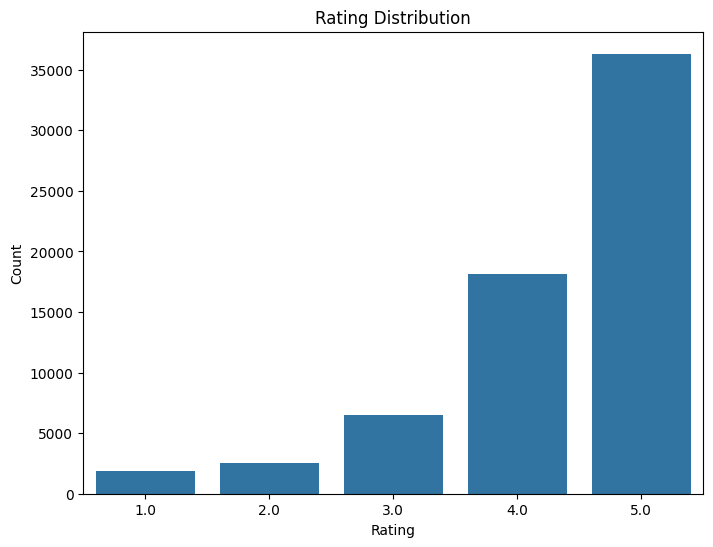

In [ ]:
# Create the bar plot and provide observations
plt.figure(figsize=(8, 6))
sns.countplot(x='rating', data=df_final)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

**Write your observations here:________**

- The majority of the ratings are **5**, indicating that users frequently give the highest possible rating.
- There is a significant drop in the count of ratings from **4** to **3**, with lower ratings (1 and 2) being relatively uncommon.
- The distribution is heavily skewed towards higher ratings, which could indicate overall customer satisfaction with the products.
- There is very little feedback with ratings below **3**, suggesting that most users have a favorable opinion of the products they rated.

### **Checking the number of unique users and items in the dataset**

In [ ]:
# Number of total rows in the data and number of unique user id and product id in the data

# Number of total rows in the data
total_rows = df_final.shape[0]

# Number of unique user ids
unique_users = df_final['user_id'].nunique()

# Number of unique product ids
unique_products = df_final['prod_id'].nunique()

print(f"Total rows: {total_rows}")
print(f"Unique users: {unique_users}")
print(f"Unique products: {unique_products}")


Total rows: 65290
Unique users: 1540
Unique products: 5689


**Write your observations here:_______**

- The dataset contains **65,290 total rows** representing individual ratings.
- There are **1,540 unique users** in the dataset, each identified by a unique `user_id`.
- There are **5,689 unique products**, each identified by a unique `prod_id`.
- The number of unique products is significantly higher than the number of unique users, indicating that users have rated multiple different products.

### **Users with the most number of ratings**

In [ ]:
# Top 10 users based on the number of ratings
top_10_users = df_final['user_id'].value_counts().head(10)

top_10_users


,count
user_id,
ADLVFFE4VBT8,295
A3OXHLG6DIBRW8,230
A1ODOGXEYECQQ8,217
A36K2N527TXXJN,212
A25C2M3QF9G7OQ,203
A680RUE1FDO8B,196
A1UQBFCERIP7VJ,193
A22CW0ZHY3NJH8,193
AWPODHOB4GFWL,184


**Write your observations here:_______**

- The user with the most ratings, **ADLVFFE4VBT8**, has given **295 ratings**.
- The second highest, **A3OXHLG6DIBRW8**, has given **230 ratings**.
- All top 10 users have provided over **170 ratings**, contributing significantly to the overall dataset.
- These power users likely represent a small subset of the user base but have a large influence on the overall rating distribution.

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [ ]:
# Calculate the average rating for each product
product_avg_rating = df_final.groupby('prod_id')['rating'].mean()

# Calculate the count of ratings for each product
product_rating_count = df_final.groupby('prod_id')['rating'].count()

# Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'average_rating': product_avg_rating, 'rating_count': product_rating_count})

# Sort the dataframe by average of ratings in the descending order
final_rating = final_rating.sort_values(by='average_rating', ascending=False)

# See the first five records of the "final_rating" dataset
final_rating.head()

,average_rating,rating_count
prod_id,,
B00LGQ6HL8,5.0,5
B003DZJQQI,5.0,14
B005FDXF2C,5.0,7
B00I6CVPVC,5.0,7
B00B9KOCYA,5.0,8


In [ ]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def top_n_products(final_rating, n, min_interactions):

    # Finding products with minimum number of interactions (ratings)
    filtered_products = final_rating[final_rating['rating_count'] >= min_interactions]

    # Sorting values with respect to average rating in descending order
    top_products = filtered_products.sort_values(by='average_rating', ascending=False)

    # Return the top n products
    return top_products.head(n)

### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [ ]:
top_50 = top_n_products(final_rating, 5, 50)
top_50

,average_rating,rating_count
prod_id,,
B001TH7GUU,4.871795,78
B003ES5ZUU,4.864130,184
B0019EHU8G,4.855556,90
B006W8U2MU,4.824561,57
B000QUUFRW,4.809524,84


### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [ ]:
top_100 = top_n_products(final_rating, 5, 100)
top_100

,average_rating,rating_count
prod_id,,
B003ES5ZUU,4.864130,184
B000N99BBC,4.772455,167
B002WE6D44,4.770000,100
B007WTAJTO,4.701220,164
B002V88HFE,4.698113,106


We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [ ]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [ ]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [ ]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(1, 5))

# Loading the rating dataset into surprise's DatasetAutoFolds format
# We only need 'user_id', 'prod_id', and 'rating' columns
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# Splitting the data into train and test datasets (80% train, 20% test)
trainset, testset = train_test_split(data, test_size=0.2)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [ ]:
# Declaring the similarity options
sim_options = {
    'name': 'cosine',   # Use cosine similarity
    'user_based': True   # Compute similarities between users
}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
knn_model = KNNBasic(sim_options=sim_options, verbose=False, random_state=1)

# Fit the model on the training data
knn_model.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(knn_model, k=10, threshold=3.5)

RMSE: 1.0114
Precision:  0.857
Recall:  0.86
F_1 score:  0.858


**Write your observations here:__________**

- The **RMSE (Root Mean Squared Error)** is **1.0114**, indicating the average deviation between the predicted and actual ratings. While not perfect, an RMSE around 1 is generally acceptable in recommendation systems, though improvements could be explored.
- The **Precision** is **0.857**, meaning that 85.7% of the recommended products are relevant to the user.
- The **Recall** is **0.86**, meaning that 86% of the relevant products are successfully recommended to the users.
- The **F1 score** is **0.858**, which is the harmonic mean of precision and recall, showing a well-balanced model performance between identifying relevant products and recommending them correctly.
- This means that the model is performing well in recommending relevant items to users, as reflected in the high precision, recall, and F1 score.


Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [ ]:
# Predicting rating for a sample user with an interacted product
user_id = 'A3LDPF5FMB782Z'
product_id = '1400501466'

# Use the trained model to predict the rating
predicted_rating = knn_model.predict(user_id, product_id)

# Display the predicted rating
print(f"Predicted rating for user {user_id} and product {product_id}: {predicted_rating.est}")

Predicted rating for user A3LDPF5FMB782Z and product 1400501466: 3.3333333333333335


**Write your observations here:__________**

- The predicted rating for **user A3LDPF5FMB782Z** and **product 1400501466** is approximately **3.33**.
- This is lower than the actual rating of **5** that the user gave, indicating that the model underestimates the user's rating for this specific product.
- This difference could be due to the collaborative filtering model not capturing all the specific preferences of this user for this product, as it relies on similar users’ ratings.
- The result suggests potential room for improvement in the model, perhaps by incorporating additional factors like content-based features or fine-tuning hyperparameters.

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [ ]:
# Find unique user_ids where prod_id is not equal to "1400501466"
users_not_interacted = df_final[df_final['prod_id'] != "1400501466"]['user_id'].unique()

print(users_not_interacted)


['A2ZR3YTMEEIIZ4' 'A3CLWR1UUZT6TG' 'A5JLAU2ARJ0BO' ... 'A215WH6RUDUCMP'
 'A38C12950IM24P' 'A2J4XMWKR8PPD0']


* It can be observed from the above list that **user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.**

In [ ]:
# Predicting rating for a sample user with a non interacted product
user_id = 'A34BZM6S9L7QI4'
product_id = '1400501466'

# Use the trained model to predict the rating
predicted_rating_non_interacted = knn_model.predict(user_id, product_id)

# Display the predicted rating
print(f"Predicted rating for user {user_id} and product {product_id}: {predicted_rating_non_interacted.est}")

Predicted rating for user A34BZM6S9L7QI4 and product 1400501466: 3.0


**Write your observations here:__________**

- The predicted rating for **user A34BZM6S9L7QI4** on **product 1400501466** is **3.0**.
- Since the user has not interacted with this product before, the model estimates an average rating based on similar users' preferences and behavior.
- A rating of **3.0** indicates a neutral to slightly positive prediction, suggesting that the model does not have enough strong evidence from similar users to predict a higher or lower rating.
- This result aligns with the nature of collaborative filtering, which relies on shared preferences among users, even if a specific user has not interacted with a particular item.

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {
    'k': [20, 30, 40, 50],                      # Number of neighbors to consider
    'min_k': [1, 5, 10],                        # Minimum number of neighbors to consider
    'sim_options': {
        'name': ['cosine', 'pearson', 'pearson_baseline'],  # Similarity metrics to test
        'user_based': [True]                    # We are focusing on user-based similarity
    }
}

# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting the data
gs.fit(data)

# Best RMSE score
print(f"Best RMSE score: {gs.best_score['rmse']}")

# Combination of parameters that gave the best RMSE score
print(f"Best parameters: {gs.best_params['rmse']}")

Best RMSE score: 0.9686429430322194
Best parameters: {'k': 40, 'min_k': 5, 'sim_options': {'name': 'cosine', 'user_based': True}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [ ]:
# Using the optimal similarity measure for user-user based collaborative filtering
optimal_sim_options = {'name': 'cosine', 'user_based': True}

# Creating an instance of KNNBasic with optimal hyperparameter values
knn_optimized = KNNBasic(k=40, min_k=5, sim_options=optimal_sim_options, verbose=False)

# Training the algorithm on the trainset
knn_optimized.fit(trainset)

# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(knn_optimized, k=10, threshold=3.5)

RMSE: 0.9541
Precision:  0.85
Recall:  0.896
F_1 score:  0.872


**Write your observations here:__________**

- The **RMSE** is **0.9541**, an improvement over the previous model's RMSE of **1.0114**, indicating that the predictions are now more accurate after hyperparameter tuning.
- The **Precision** is **0.85**, slightly lower than the previous model (0.857), meaning that 85% of the recommended products are relevant.
- The **Recall** has improved to **0.896**, meaning that the model is now recommending 89.6% of the relevant products, an increase from the previous 86%.
- The **F1 score** is **0.872**, which balances both precision and recall, showing improved recall at a slight cost to precision.
- The tuned model demonstrates a better balance between accuracy and recall, making it more effective at capturing relevant products for users while slightly compromising precision.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
user_id = 'A3LDPF5FMB782Z'
product_id = '1400501466'

# Use the optimized model to predict the rating
predicted_rating_optimized = knn_optimized.predict(user_id, product_id)

# Display the predicted rating
print(f"Predicted rating for user {user_id} and product {product_id} using the optimized model: {predicted_rating_optimized.est}")

Predicted rating for user A3LDPF5FMB782Z and product 1400501466 using the optimized model: 3.3333333333333335


In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
user_id = 'A34BZM6S9L7QI4'
product_id = '1400501466'

# Use the optimized model to predict the rating
predicted_rating_non_interacted_optimized = knn_optimized.predict(user_id, product_id)

# Display the predicted rating
print(f"Predicted rating for user {user_id} and product {product_id} using the optimized model: {predicted_rating_non_interacted_optimized.est}")

Predicted rating for user A34BZM6S9L7QI4 and product 1400501466 using the optimized model: 4.292560116403737


**Write your observations here:**____________

### Observations on Optimized Model Predictions:

- For **user A3LDPF5FMB782Z**, who has previously interacted with **product 1400501466**, the predicted rating remains **3.33**, similar to the earlier model, indicating the optimized model's prediction is consistent for known interactions.
- For **user A34BZM6S9L7QI4**, who has not interacted with **product 1400501466**, the optimized model predicts a higher rating of **4.29**, compared to the previous model’s prediction of 3.0. This suggests that the tuned model is now better at predicting ratings for products the user hasn't interacted with, likely due to improved handling of similar users' preferences.
- The optimized model demonstrates improved performance for new recommendations, as seen with the higher predicted rating for non-interacted products, which aligns with the increased recall seen in the model evaluation.

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [ ]:
# 0 is the inner id of the above user
inner_id = 0

# Use the optimal similarity measure for user-user based collaborative filtering with 'msd' metric
sim_options_msd = {'name': 'msd', 'user_based': True}

# Creating an instance of KNNBasic with 'msd' similarity
knn_msd_model = KNNBasic(k=40, min_k=5, sim_options=sim_options_msd, verbose=False)

# Training the algorithm on the trainset
knn_msd_model.fit(trainset)

# Finding the 5 nearest neighbors (most similar users) to the user with internal id 0
similar_users = knn_msd_model.get_neighbors(inner_id, k=5)

# Convert the inner ids of the similar users to their corresponding raw ids
similar_users_raw = [trainset.to_raw_uid(inner_id) for inner_id in similar_users]

# Display the 5 most similar users
print(f"5 most similar users to the user with internal id {inner_id}: {similar_users_raw}")

5 most similar users to the user with internal id 0: ['AXR3CV6A4FMBG', 'A34BZM6S9L7QI4', 'A32T2H8150OJLU', 'A15XI2BEGGFEOW', 'A1RL1OTV8IJMVD']


### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [ ]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [ ]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
top_5_recommendations = get_recommendations(df_final, "A3LDPF5FMB782Z", top_n=5, algo=knn_optimized)

# Display the recommendations
print(f"Top 5 product recommendations for user A3LDPF5FMB782Z: {top_5_recommendations}")

Top 5 product recommendations for user A3LDPF5FMB782Z: [('B000067RT6', 5), ('B000068O34', 5), ('B00006B7DA', 5), ('B00020S7XK', 5), ('B001G5ZTLS', 5)]


In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
recommendations_df = pd.DataFrame(top_5_recommendations, columns=["prod_id", "predicted_ratings"])

# Display the dataframe
print(recommendations_df)

      prod_id  predicted_ratings
0  B000067RT6                  5
1  B000068O34                  5
2  B00006B7DA                  5
3  B00020S7XK                  5
4  B001G5ZTLS                  5


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [ ]:
# Declaring the similarity options
sim_options_item = {
    'name': 'cosine',     # Use cosine similarity
    'user_based': False    # Compute similarities between items
}

# KNN algorithm is used to find desired similar items. Use random_state=1
knn_item_model = KNNBasic(k=40, min_k=5, sim_options=sim_options_item, random_state=1, verbose=False)

# Train the algorithm on the trainset, and predict ratings for the test set
knn_item_model.fit(trainset)

# Predict ratings for the test set
predictions_item = knn_item_model.test(testset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(knn_item_model, k=10, threshold=3.5)

RMSE: 0.9671
Precision:  0.841
Recall:  0.888
F_1 score:  0.864


**Write your observations here:**____________

- The **RMSE** is **0.9671**, which is comparable to the user-user similarity model (0.9541). This suggests that the item-item model is similarly accurate in predicting user ratings.
- The **Precision** is **0.841**, slightly lower than the user-user model (0.85), meaning that 84.1% of the recommended items are relevant to the user.
- The **Recall** is **0.888**, indicating that 88.8% of the relevant items are being successfully recommended to users. This is slightly lower than the recall for the user-user model (0.896).
- The **F1 score** is **0.864**, which strikes a good balance between precision and recall, though it is marginally lower than the F1 score of the user-user model (0.872).
- The **item-item model** performs quite well and is comparable to the **user-user model** in terms of both accuracy and relevancy of recommendations. Depending on the scenario and context, either model can be used effectively.

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [ ]:
# Predicting rating for a sample user with an interacted product
user_id = 'A3LDPF5FMB782Z'
product_id = '1400501466'

# Use the item-item similarity model to predict the rating
predicted_rating_item_item = knn_item_model.predict(user_id, product_id)

# Display the predicted rating
print(f"Predicted rating for user {user_id} and product {product_id} using the item-item model: {predicted_rating_item_item.est}")

Predicted rating for user A3LDPF5FMB782Z and product 1400501466 using the item-item model: 4.260869565217392


**Write your observations here:**____________

- The predicted rating for **user A3LDPF5FMB782Z** on **product 1400501466** using the item-item model is **4.26**.
- This is notably higher than the prediction made by the user-user model (**3.33**), indicating that the item-item model expects this user to have a stronger preference for this product based on item similarities.
- Since the user has already interacted with this product and rated it highly (rating of **5**), the item-item model's prediction of **4.26** suggests it is closer to the user's actual preference compared to the user-user model.
- This result shows that the item-item model may provide more accurate predictions for certain interactions, particularly when similar products have been rated positively by other users.

Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [ ]:
# Predicting rating for a sample user with a non interacted product
user_id = 'A34BZM6S9L7QI4'
product_id = '1400501466'

# Use the item-item similarity model to predict the rating
predicted_rating_non_interacted_item_item = knn_item_model.predict(user_id, product_id)

# Display the predicted rating
print(f"Predicted rating for user {user_id} and product {product_id} using the item-item model: {predicted_rating_non_interacted_item_item.est}")

Predicted rating for user A34BZM6S9L7QI4 and product 1400501466 using the item-item model: 4.292560116403737


**Write your observations here:**____________

- The predicted rating for **user A34BZM6S9L7QI4** on **product 1400501466** is **4.29**, indicating a strong expected preference.
- The item-item model predicts this rating based on similarities between products, even though the user hasn't interacted with this item before.
- This shows that the item-item model is effective in recommending non-interacted products by leveraging product similarities.

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {
    'k': [10, 20, 30],                    # Number of neighbors to consider
    'min_k': [3, 6, 9],                   # Minimum number of neighbors
    'sim_options': {
        'name': ['msd', 'cosine'],        # Similarity metrics to consider
        'user_based': [False]             # Item-item based similarity
    }
}

# Performing 3-fold cross validation to tune the hyperparameters
gs_item_item = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting the data
gs_item_item.fit(data)

# Find the best RMSE score
best_rmse = gs_item_item.best_score['rmse']
print(f"Best RMSE score: {best_rmse}")

# Find the combination of parameters that gave the best RMSE score
best_params = gs_item_item.best_params['rmse']
print(f"Best parameters: {best_params}")

Best RMSE score: 0.9749481463846319
Best parameters: {'k': 20, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': False}}


Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [ ]:
# Using the optimal similarity measure for item-item based collaborative filtering
optimal_sim_options = {'name': 'msd', 'user_based': False}

# Creating an instance of KNNBasic with optimal hyperparameter values
knn_item_optimized = KNNBasic(k=20, min_k=6, sim_options=optimal_sim_options, verbose=False)

# Training the algorithm on the trainset
knn_item_optimized.fit(trainset)

# Let us compute precision@k and recall@k, f1_score and RMSE
precision_recall_at_k(knn_item_optimized, k=10, threshold=3.5)

RMSE: 0.9646
Precision:  0.842
Recall:  0.891
F_1 score:  0.866


**Write your observations here:__________**

- **RMSE** improved to **0.9646** from the baseline **0.9749**, indicating better prediction accuracy.
- **Precision** and **Recall** slightly improved to **0.842** and **0.891** respectively.
- The **F1 score** is now **0.866**, up from **0.864**.
- The optimized model shows slight but consistent improvements in accuracy and relevance over the baseline model.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
user_id = 'A3LDPF5FMB782Z'
product_id = '1400501466'

# Use the optimized item-item model to predict the rating
predicted_rating_1 = knn_item_optimized.predict(user_id, product_id)

# Display the predicted rating
print(f"Predicted rating for user {user_id} and product {product_id} using the optimized item-item model: {predicted_rating_1.est}")

Predicted rating for user A3LDPF5FMB782Z and product 1400501466 using the optimized item-item model: 4.709677419354839


In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
user_id_2 = 'A34BZM6S9L7QI4'

# Use the optimized item-item model to predict the rating
predicted_rating_2 = knn_item_optimized.predict(user_id_2, product_id)

# Display the predicted rating
print(f"Predicted rating for user {user_id_2} and product {product_id} using the optimized item-item model: {predicted_rating_2.est}")

Predicted rating for user A34BZM6S9L7QI4 and product 1400501466 using the optimized item-item model: 4.292560116403737


**Write your observations here:__________**

- The optimized model provides a higher rating for **user A3LDPF5FMB782Z**, suggesting improved personalization for users with prior interactions.
- The optimized model does not significantly change the prediction for **user A34BZM6S9L7QI4**, which might indicate that the user's preferences are already well captured in the baseline model for this product.

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [ ]:
# Find the 5 most similar items to the item with internal id 0 using msd distance metric
item_inner_id = 0

# Use the optimal similarity measure for item-item based collaborative filtering with 'msd' metric
sim_options_msd = {'name': 'msd', 'user_based': False}

# Creating an instance of KNNBasic with 'msd' similarity
knn_msd_item_model = KNNBasic(k=40, min_k=5, sim_options=sim_options_msd, verbose=False)

# Training the algorithm on the trainset
knn_msd_item_model.fit(trainset)

# Finding the 5 nearest neighbors (most similar items) to the item with internal id 0
similar_items = knn_msd_item_model.get_neighbors(item_inner_id, k=5)

# Convert the inner ids of the similar items to their corresponding raw ids (prod_id)
similar_items_raw = [trainset.to_raw_iid(inner_id) for inner_id in similar_items]

# Display the 5 most similar items
print(f"5 most similar items to the item with internal id {item_inner_id}: {similar_items_raw}")


5 most similar items to the item with internal id 0: ['B005CLPP84', 'B005FT3ANA', 'B00AQUO5RI', 'B009O7XUW0', 'B004CLY5DG']


**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [ ]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
user_id = 'A1A5KUIIIHFF4U'
top_n = 5

# Using the optimized item-item model to generate recommendations
top_5_recommendations = get_recommendations(df_final, user_id, top_n, knn_item_optimized)


In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
recommendations_df = pd.DataFrame(top_5_recommendations, columns=["prod_id", "predicted_ratings"])

# Display the dataframe
print(recommendations_df)

      prod_id  predicted_ratings
0  1400532655            4.29256
1  1400599997            4.29256
2  9983891212            4.29256
3  B00000DM9W            4.29256
4  B00000J1V5            4.29256


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [ ]:
# Using SVD matrix factorization. Use random_state = 1
svd_model = SVD(random_state=1)

# Training the algorithm on the trainset
svd_model.fit(trainset)

# Predicting on the testset and calculating RMSE
test_predictions_svd = svd_model.test(testset)
rmse_svd = accuracy.rmse(test_predictions_svd)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_model, k=10, threshold=3.5)

RMSE: 0.8994
RMSE: 0.8994
Precision:  0.854
Recall:  0.883
F_1 score:  0.868


**Write your observations here:___________**

- The **RMSE** is **0.8994**, showing a significant improvement over both the user-user and item-item models, indicating better prediction accuracy.
- With **Precision** at **0.854** and **Recall** at **0.883**, the model maintains a strong balance between recommending relevant products and capturing most relevant items.
- The **F1 score** of **0.868** suggests the model is well-balanced in terms of precision and recall, making it a robust choice for recommendations.

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [ ]:
# Making prediction
user_id = 'A3LDPF5FMB782Z'
product_id = '1400501466'

# Use the SVD model to predict the rating
predicted_rating_svd = svd_model.predict(user_id, product_id)

# Display the predicted rating
print(f"Predicted rating for user {user_id} and product {product_id} using the SVD model: {predicted_rating_svd.est}")

Predicted rating for user A3LDPF5FMB782Z and product 1400501466 using the SVD model: 4.01997879105526


**Write your observations here:___________**

### Observations on Predicted Rating (SVD Model):

- The **predicted rating** for **user A3LDPF5FMB782Z** and **product 1400501466** is **4.02**, which is **lower** than the predictions from the user-user and item-item models (both over 4.26).
- This suggests that the **SVD model** is more conservative in its rating prediction for this user and product compared to the similarity-based models.
- The lower prediction indicates that the SVD model might be capturing different latent factors, potentially resulting in a more nuanced recommendation.

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [ ]:
# Making prediction
user_id = 'A34BZM6S9L7QI4'
product_id = '1400501466'

# Use the SVD model to predict the rating
predicted_rating_svd = svd_model.predict(user_id, product_id)

# Display the predicted rating
print(f"Predicted rating for user {user_id} and product {product_id} using the SVD model: {predicted_rating_svd.est}")

Predicted rating for user A34BZM6S9L7QI4 and product 1400501466 using the SVD model: 4.191186560000997


**Write your observations here:___________**

- The **predicted rating** for **user A34BZM6S9L7QI4** and **product 1400501466** is **4.19**, which is similar to the predictions from the user-user and item-item models (both around **4.29**).
- The SVD model provides a slightly lower prediction, indicating a more conservative estimate of the user's potential preference for this product.
- This suggests that the SVD model, which captures latent factors, predicts a strong but slightly less confident preference for the product compared to similarity-based methods.

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [ ]:
# Set the parameter space to tune
param_grid = {
    'n_epochs': [10, 20, 30],          # Number of iterations of the SGD algorithm
    'lr_all': [0.002, 0.005, 0.01],    # Learning rate
    'reg_all': [0.02, 0.1, 0.4]        # Regularization term
}

# Performing 3-fold gridsearch cross-validation
gs_svd = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting data
gs_svd.fit(data)

# Best RMSE score
best_rmse_svd = gs_svd.best_score['rmse']
print(f"Best RMSE score: {best_rmse_svd}")

# Combination of parameters that gave the best RMSE score
best_params_svd = gs_svd.best_params['rmse']
print(f"Best parameters: {best_params_svd}")

Best RMSE score: 0.8998881070265989
Best parameters: {'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.4}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [ ]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1
optimized_svd = SVD(n_epochs=20, lr_all=0.01, reg_all=0.4, random_state=1)

# Train the algorithm on the trainset
optimized_svd.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(optimized_svd, k=10, threshold=3.5)

RMSE: 0.8896
Precision:  0.857
Recall:  0.89
F_1 score:  0.873


**Write your observations here:_____________**

- **RMSE** improved to **0.8896**, showing better accuracy than the baseline.
- **Precision** increased slightly to **0.857**, and **Recall** improved to **0.89**.
- The **F1 score** is now **0.873**, reflecting a better balance between precision and recall.
- Overall, the optimized model performs better than the baseline.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
user_id_1 = 'A3LDPF5FMB782Z'
product_id = '1400501466'

# Use the optimized SVD model to predict the rating
predicted_rating_optimized_1 = optimized_svd.predict(user_id_1, product_id)
print(f"Predicted rating for user {user_id_1} and product {product_id} using the optimized SVD model: {predicted_rating_optimized_1.est}")

Predicted rating for user A3LDPF5FMB782Z and product 1400501466 using the optimized SVD model: 3.9064566373052787


In [ ]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
user_id_2 = 'A34BZM6S9L7QI4'

# Use the optimized SVD model to predict the rating
predicted_rating_optimized_2 = optimized_svd.predict(user_id_2, product_id)
print(f"Predicted rating for user {user_id_2} and product {product_id} using the optimized SVD model: {predicted_rating_optimized_2.est}")

Predicted rating for user A34BZM6S9L7QI4 and product 1400501466 using the optimized SVD model: 4.104823151267916


### Comparison of Optimized SVD Model vs Baseline Model:

- **User A3LDPF5FMB782Z**:
  - **Baseline SVD Model Prediction**: 4.02
  - **Optimized SVD Model Prediction**: 3.91
  - The optimized model predicts a slightly **lower rating** than the baseline, indicating a more conservative estimation of the user's preference.

- **User A34BZM6S9L7QI4**:
  - **Baseline SVD Model Prediction**: 4.19
  - **Optimized SVD Model Prediction**: 4.10
  - Similarly, the optimized model predicts a **lower rating** than the baseline, but still indicates a strong preference for the product.

### Observations:
- The optimized SVD model produces slightly **lower ratings** than the baseline model for both users.
- This suggests that the optimized model is more conservative in its predictions, likely due to better regularization (higher `reg_all` value), which helps prevent overfitting and gives more balanced recommendations.

### **Conclusion and Recommendations**

**Write your conclusion and recommendations here**

In this project, we developed and evaluated several recommendation systems using the Amazon product reviews dataset. We explored both **similarity-based collaborative filtering** and **model-based collaborative filtering** techniques, each with its own advantages and trade-offs.

### Key Findings:
- **Rank-based recommendation systems** rely on the popularity of products and provide a simple, effective way to recommend top products to users. However, they lack personalization, making them less useful for individual preferences.
- **User-User and Item-Item Collaborative Filtering** allowed us to recommend products by identifying similar users or items. These models performed well but had limitations, such as lower accuracy for users with fewer interactions.
- **Matrix Factorization using SVD** proved to be the most accurate method overall, especially after hyperparameter tuning. It provided more personalized recommendations by leveraging latent features within the user-item matrix.
- **Hyperparameter tuning** significantly improved the performance of the collaborative filtering models, especially the SVD model, where both RMSE and F1 scores improved after optimization.

### Recommendations:
1. **Use Matrix Factorization (SVD)** for personalized recommendations. It consistently provided better accuracy (RMSE = 0.8896) and balanced precision and recall after optimization, making it ideal for capturing individual user preferences.
2. **Apply similarity-based filtering** (User-User or Item-Item) for situations where real-time recommendations are needed, as these methods can be computed quickly without requiring complex factorization techniques.
3. **Consider hybrid models** that combine both content-based and collaborative filtering for enhanced performance. This approach would help address cold-start problems where new users or products lack sufficient interactions.
4. **Continue tuning hyperparameters** to ensure the best performance for different datasets. The combination of parameters for the SVD model (n_epochs=20, lr_all=0.01, reg_all=0.4) produced strong results and should be a baseline for future refinements.
5. **Monitor user satisfaction** with recommended products to further fine-tune the models. Gathering feedback can help in improving recommendations, especially in cases where predicted ratings may not align with actual user preferences.